# ABCD Yields

In [2]:
import uproot
import ROOT as r
import numpy as np

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)

In [3]:
def get_abcd(file, tree="Events"):
    with uproot.open(file) as f:
        df = f.get(tree).arrays(library="pd")

    BDT_CUT = 0.56
    DNN_CUT = 0.92

    a = df.query("VBSBDTscore > @BDT_CUT & abcdnet_score > @DNN_CUT").weight
    b = df.query("VBSBDTscore > @BDT_CUT & abcdnet_score < @DNN_CUT").weight
    c = df.query("VBSBDTscore < @BDT_CUT & abcdnet_score > @DNN_CUT").weight
    d = df.query("VBSBDTscore < @BDT_CUT & abcdnet_score < @DNN_CUT").weight

    err_a = np.sqrt((a**2).sum())
    err_b = np.sqrt((b**2).sum())
    err_c = np.sqrt((c**2).sum())
    err_d = np.sqrt((d**2).sum())

    a = a.sum()
    b = b.sum()
    c = c.sum()
    d = d.sum()

    if "data_MVA" in file:
        a = np.array(1)

    print(f"Actual A: {a} \\pm {err_a}")
    print(f"Region B: {b} \\pm {err_b}")
    print(f"Region C: {c} \\pm {err_c}")
    print(f"Region D: {d} \\pm {err_d}")

    err_pwhite_a = np.sqrt((err_b * c / d) ** 2 + (err_c * b / d) ** 2 + ((b * c / d**2) * err_d) ** 2)

    print(f"Pwhiteicted A: {b * c / d} \\pm {err_pwhite_a}")

    return a, b, c, d

# DATA

In [4]:
data = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/data_MVA_abcdnet.root")

Actual A: 1 \pm 1.0
Region B: 78 \pm 8.831760866327848
Region C: 11 \pm 3.3166247903554
Region D: 1013 \pm 31.827660925679098
Pwhiteicted A: 0.8469891411648569 \pm 0.27408543816219094


In [5]:
# data_cr = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/data_cr_MVA_abcdnet.root")

Text(72.70833333333333, 1, 'ABCDNet Score')

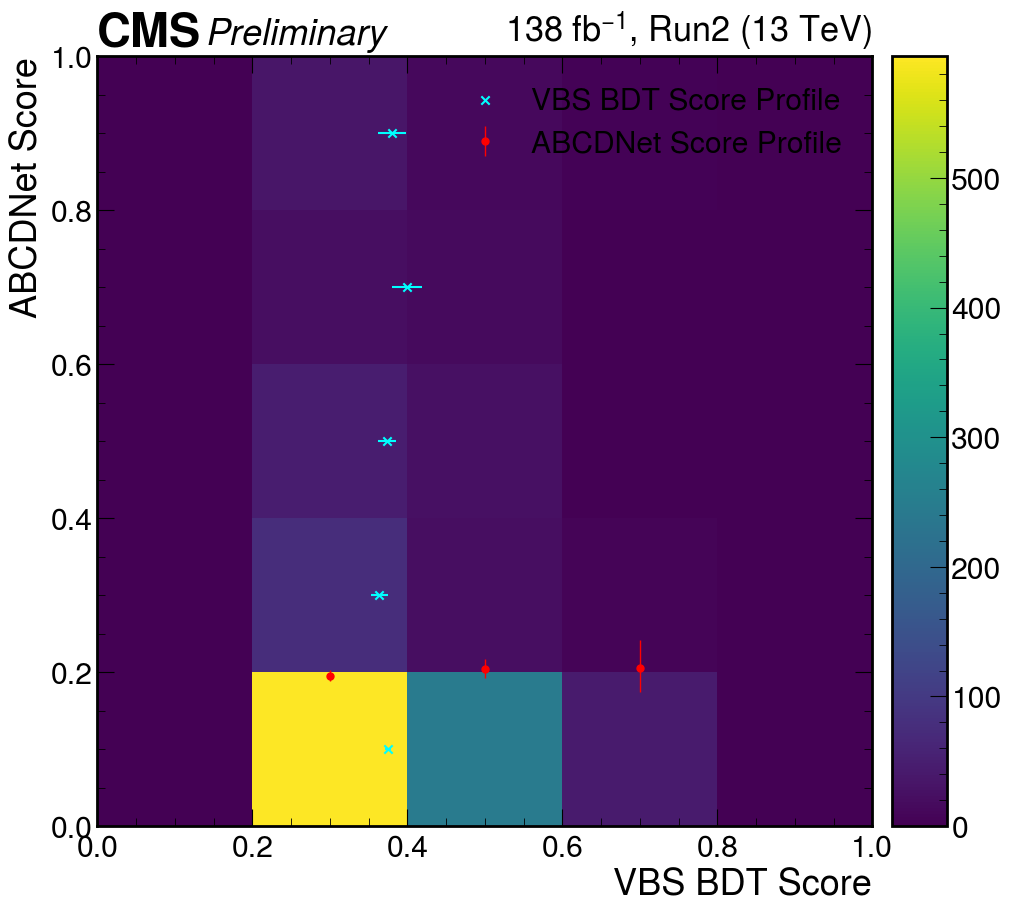

In [9]:
df = r.RDataFrame("Events", "/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/data_MVA_abcdnet.root")
hist = df.Histo2D(("h", "2D histogram", 5, 0, 1, 5, 0, 1), "VBSBDTscore", "abcdnet_score").GetValue()

h = uproot.from_pyroot(hist).to_hist()

fig, ax = plt.subplots()
hep.hist2dplot(h, cbar=True, ax=ax, )
hep.histplot(h.profile("yaxis"), ax=ax, histtype="errorbar", color="red", label="ABCDNet Score Profile")
ax.scatter(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, color="cyan", marker="x", label="VBS BDT Score Profile")
ax.errorbar(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, xerr=np.sqrt(h.profile("xaxis").variances()), fmt="none", color="cyan", markersize=1)

hep.cms.label(data=True, label="Preliminary", lumi=138, year="Run2", ax=ax)

ax.legend(loc="upper right")

ax.set_xlabel("VBS BDT Score")
ax.set_ylabel("ABCDNet Score")

# plt.savefig("/home/users/aaarora/phys/analysis/vbs-1lep/plotting/plots/data_abcdnet_bdt_correlation.png")

# SIG

In [7]:
data = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/sig_MVA_abcdnet.root")

Actual A: 3.651707521299207 \pm 0.024828333321467416
Region B: 1.1678695583992402 \pm 0.015337168059810051
Region C: 0.8593609774220464 \pm 0.012581330951505421
Region D: 0.5358977092893433 \pm 0.01127617799766611
Pwhiteicted A: 1.8727856227232849 \pm 0.053940001783266425


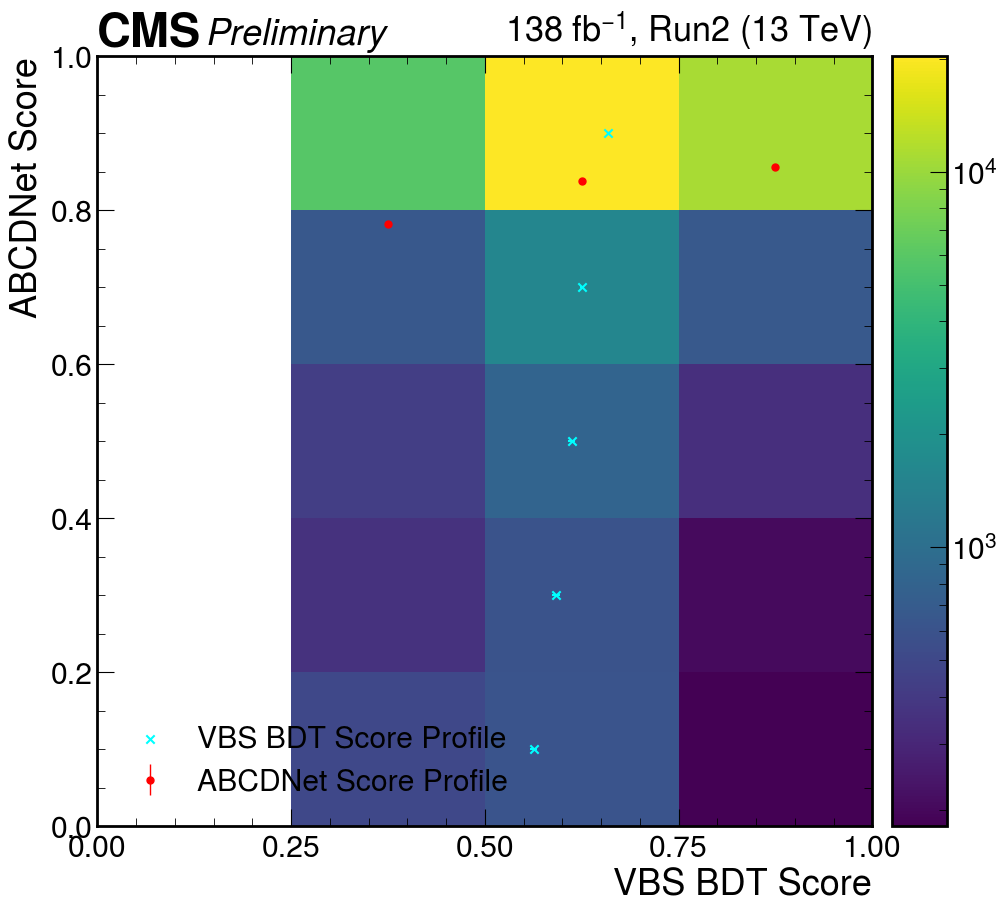

In [14]:
df = r.RDataFrame("Events", "/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/sig_MVA_abcdnet.root")
hist = df.Histo2D(("h", "2D histogram", 4, 0, 1, 5, 0, 1), "VBSBDTscore", "abcdnet_score").GetValue()

h = uproot.from_pyroot(hist).to_hist()

fig, ax = plt.subplots()
hep.hist2dplot(h, cbar=True, ax=ax, norm="log")
hep.histplot(h.profile("yaxis"), ax=ax, histtype="errorbar", color="red", label="ABCDNet Score Profile")
ax.scatter(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, color="cyan", marker="x", label="VBS BDT Score Profile")
ax.errorbar(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, xerr=np.sqrt(h.profile("xaxis").variances()), fmt="none", color="cyan", markersize=1)

hep.cms.label(data=True, label="Preliminary", lumi=138, year="Run2", ax=ax)

ax.legend(loc="lower left")

ax.set_xlabel("VBS BDT Score")
ax.set_ylabel("ABCDNet Score")

plt.savefig("/home/users/aaarora/phys/analysis/vbs-1lep/plotting/plots/sig_abcdnet_bdt_correlation.png")

# BKG

In [9]:
data = get_abcd("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/bkg_MVA_abcdnet.root")

Actual A: 1.5963017523921363 \pm 0.37514271664311294
Region B: 74.8811095308275 \pm 3.7271667062319263
Region C: 17.97963009291327 \pm 1.7927155097813001
Region D: 987.8551083593767 \pm 11.191316135724286
Pwhiteicted A: 1.3628867623584844 \pm 0.15266494197933148


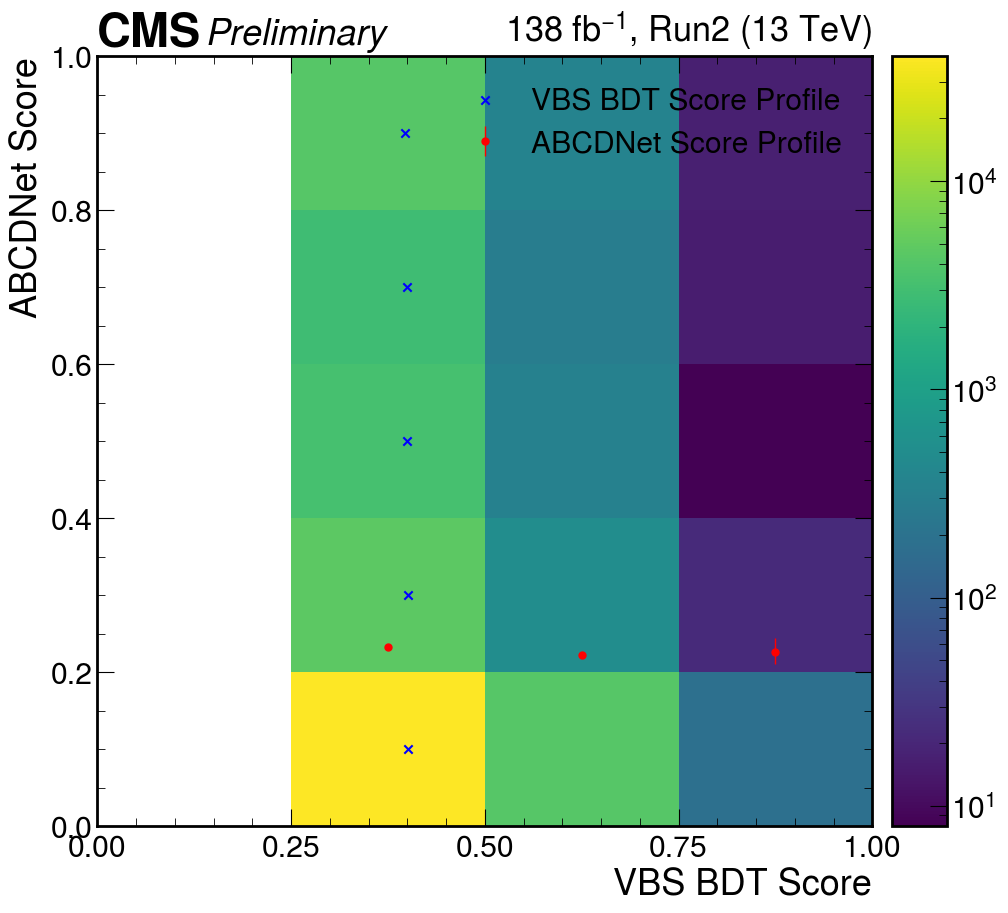

In [18]:
df = r.RDataFrame("Events", "/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/bkg_MVA_abcdnet.root")
hist = df.Histo2D(("h", "2D histogram", 4, 0, 1, 5, 0, 1), "VBSBDTscore", "abcdnet_score").GetValue()

h = uproot.from_pyroot(hist).to_hist()

fig, ax = plt.subplots()
hep.hist2dplot(h, cbar=True, ax=ax, norm="log")
hep.histplot(h.profile("yaxis"), ax=ax, histtype="errorbar", color="red", label="ABCDNet Score Profile")
ax.scatter(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, color="blue", marker="x", label="VBS BDT Score Profile")
ax.errorbar(h.profile("xaxis").to_numpy()[0], h.profile("xaxis").to_numpy()[1][:-1] + 0.1, xerr=np.sqrt(h.profile("xaxis").variances()), fmt="none", color="blue")

hep.cms.label(data=True, label="Preliminary", lumi=138, year="Run2", ax=ax)
ax.legend(loc="upper right", )

ax.set_xlabel("VBS BDT Score")
ax.set_ylabel("ABCDNet Score")

plt.savefig("/home/users/aaarora/phys/analysis/vbs-1lep/plotting/plots/bkg_abcdnet_bdt_correlation.png")